In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv").values
np.random.shuffle(data)

In [3]:
X = data[:, 1:] / 255.0
Y = data[:, 0]
#X: pixel data, normalized from [0, 255] to [0, 1].

In [4]:
X = X.reshape(-1, 1, 28, 28).astype(np.float32)
Y = Y.astype(np.int64)
# [batch_size, channels, height, width] = [N, 1, 28, 28]

In [5]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.1, random_state=42)
# 90% for training, 10% for testing
X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)
X_dev_tensor = torch.tensor(X_dev)
Y_dev_tensor = torch.tensor(Y_dev)

In [6]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, Y_dev_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False)
#batch size 64 is batch training

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # → [batch, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))   # → [batch, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.1218
Epoch 2/10, Loss: 0.0754
Epoch 3/10, Loss: 0.2218
Epoch 4/10, Loss: 0.0603
Epoch 5/10, Loss: 0.0002
Epoch 6/10, Loss: 0.0059
Epoch 7/10, Loss: 0.0332
Epoch 8/10, Loss: 0.0007
Epoch 9/10, Loss: 0.0167
Epoch 10/10, Loss: 0.0351


In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, Y_batch in dev_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 98.45%


In [11]:
def test_prediction(index):
    image = X_dev_tensor[index]
    label = Y_dev_tensor[index].item()

    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        prediction = torch.argmax(output).item()

    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title(f"Predicted: {prediction}, Label: {label}")
    plt.axis('off')
    plt.show()

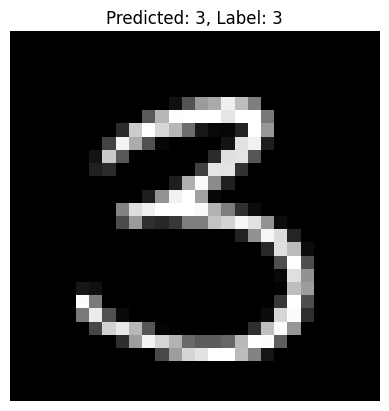

In [12]:
test_prediction(110)